# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf code data_processing logs models code state.db
!rm 1_run_scraper_into_dataset.ipynb 2_train_the_classification_model.ipynb requirements.txt

In [2]:
!git clone -b feat/pretrained-model https://github.com/luthfiarifin/hybrid-envit-car-retrieval.git code
!mv code/* .
!ls

Cloning into 'code'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 58 (delta 5), reused 12 (delta 4), pack-reused 43 (from 1)
Receiving objects: 100% (58/58), 58.14 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (9/9), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing  requirements.txt


In [ ]:
IS_IMPORT_FROM_KAGGLE = True

if IS_IMPORT_FROM_KAGGLE:
    import kagglehub
    DATASET_DIR = kagglehub.dataset_download("muhammadluthfiarifin/indonesian-cars-classification-dataset", path="dataset")
else:
    DATASET_DIR = "data_processing/data/dataset"

In [ ]:
# Import required libraries

import torch
import time
from datetime import datetime

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.7.1
CUDA available: False


2025-06-23 19:12:28.223706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750705948.245856     224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750705948.252815     224 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


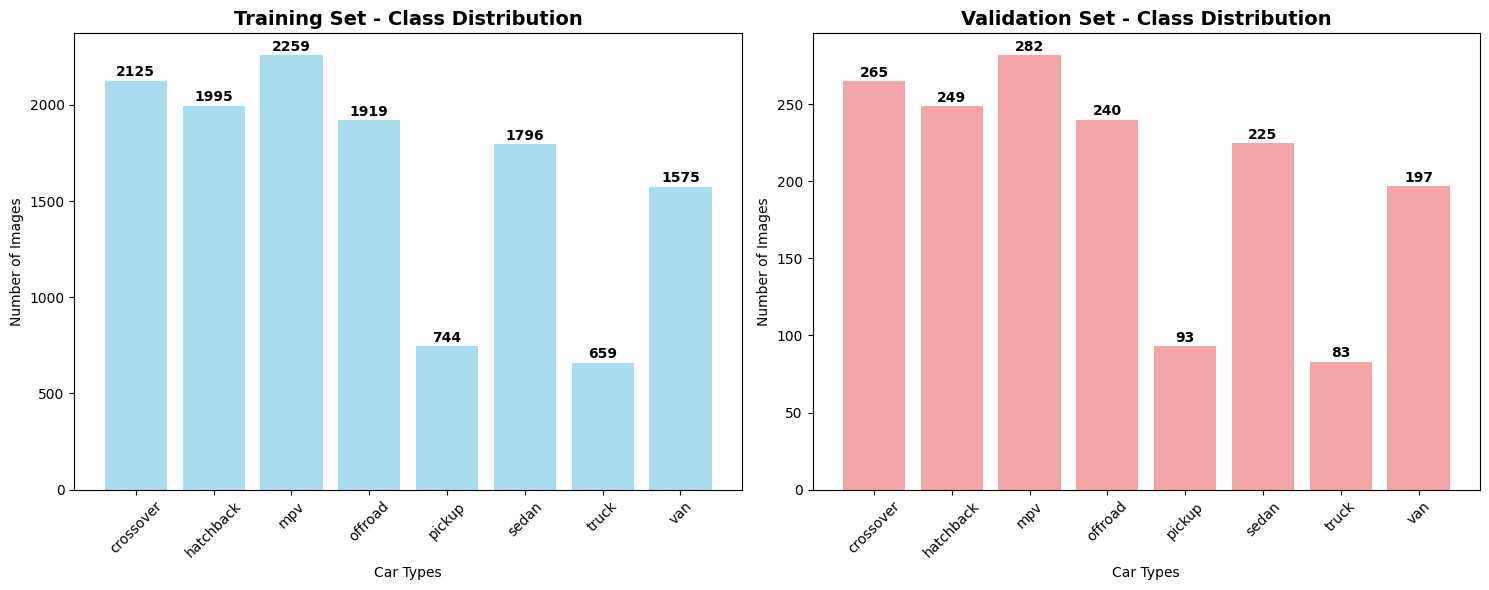


=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750705954
Loading pre-trained weights for the Hybrid Model's CNN stem.
Using weighted CrossEntropyLoss with weights: tensor([0.7689, 0.8190, 0.7233, 0.8515, 2.1962, 0.9098, 2.4795, 1.0375],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
crossover    2125     16.3      % 1.06           x
hatchback    1995     15.3      % 1.13           x
mpv          2259     17.3      % 1.00           x
offroad      1919     14.7      % 1.18           x
pickup       744      5.7       % 3.04           x
sedan        1796     13.7      % 1.26           x
truck        659      5.0       % 3.43           x
van          1575     12.0      % 1.43           x

📈 Imbalance Factor: 3.43x (Most frequent / Least frequent)
⚠️  Moderate imbalance detected. We

In [ ]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer
from models.classification.train_classification_eval import DatasetExplorer


CONFIG = {
    "train_dir": f"{DATASET_DIR}/train",
    "val_dir": f"{DATASET_DIR}/val",
    "num_classes": 8,
    "embed_dim": 192,
    "num_heads": 8,
    "dropout": 0.2,
    "learning_rate": 1e-4,
    "batch_size": 96,
    "num_epochs": 50,
    "result_path": f'models/classification/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 12,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
    "pretrained": True,
    "freeze_stem": False,
}

# Generate and summary report
explorer = DatasetExplorer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
)
explorer.summary_report()

# Initialize the trainer
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
    pretrained=CONFIG["pretrained"],
    freeze_stem=CONFIG["freeze_stem"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

In [6]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 21,767,852
Trainable parameters: 21,767,852

Epoch 1/50


100%|██████████| 137/137 [02:06<00:00,  1.09it/s, loss=1.83]


Validation accuracy: 26.93%
Validation loss: 1.8329
Train Loss: 2.0224 | Train Acc: 17.75%
Val Loss: 1.8329 | Val Acc: 26.93%
Time: 141.36s | LR: 1.00e-04
🎉 New best accuracy: 26.93%
Validation loss decreased (inf --> 1.832936).  Saving model ...

Epoch 2/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=1.65]


Validation accuracy: 35.50%
Validation loss: 1.6810
Train Loss: 1.8327 | Train Acc: 25.36%
Val Loss: 1.6810 | Val Acc: 35.50%
Time: 132.28s | LR: 1.00e-04
🎉 New best accuracy: 35.50%
Validation loss decreased (1.832936 --> 1.680976).  Saving model ...

Epoch 3/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.95]


Validation accuracy: 39.60%
Validation loss: 1.5441
Train Loss: 1.6850 | Train Acc: 31.67%
Val Loss: 1.5441 | Val Acc: 39.60%
Time: 133.28s | LR: 1.00e-04
🎉 New best accuracy: 39.60%
Validation loss decreased (1.680976 --> 1.544057).  Saving model ...

Epoch 4/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.43]


Validation accuracy: 44.74%
Validation loss: 1.4446
Train Loss: 1.5613 | Train Acc: 37.07%
Val Loss: 1.4446 | Val Acc: 44.74%
Time: 133.24s | LR: 1.00e-04
🎉 New best accuracy: 44.74%
Validation loss decreased (1.544057 --> 1.444624).  Saving model ...

Epoch 5/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=1.27]


Validation accuracy: 50.98%
Validation loss: 1.3153
Train Loss: 1.4541 | Train Acc: 41.84%
Val Loss: 1.3153 | Val Acc: 50.98%
Time: 131.97s | LR: 1.00e-04
🎉 New best accuracy: 50.98%
Validation loss decreased (1.444624 --> 1.315312).  Saving model ...

Epoch 6/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=0.837]


Validation accuracy: 53.92%
Validation loss: 1.2139
Train Loss: 1.3510 | Train Acc: 45.59%
Val Loss: 1.2139 | Val Acc: 53.92%
Time: 134.79s | LR: 1.00e-04
🎉 New best accuracy: 53.92%
Validation loss decreased (1.315312 --> 1.213891).  Saving model ...

Epoch 7/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.65]


Validation accuracy: 58.20%
Validation loss: 1.1010
Train Loss: 1.2781 | Train Acc: 49.39%
Val Loss: 1.1010 | Val Acc: 58.20%
Time: 133.46s | LR: 1.00e-04
🎉 New best accuracy: 58.20%
Validation loss decreased (1.213891 --> 1.100984).  Saving model ...

Epoch 8/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.43] 


Validation accuracy: 61.87%
Validation loss: 1.0986
Train Loss: 1.1699 | Train Acc: 53.32%
Val Loss: 1.0986 | Val Acc: 61.87%
Time: 132.87s | LR: 1.00e-04
🎉 New best accuracy: 61.87%
Validation loss decreased (1.100984 --> 1.098555).  Saving model ...

Epoch 9/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.42] 


Validation accuracy: 64.93%
Validation loss: 0.9683
Train Loss: 1.0991 | Train Acc: 56.66%
Val Loss: 0.9683 | Val Acc: 64.93%
Time: 133.31s | LR: 1.00e-04
🎉 New best accuracy: 64.93%
Validation loss decreased (1.098555 --> 0.968321).  Saving model ...

Epoch 10/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.985]


Validation accuracy: 65.79%
Validation loss: 1.0081
Train Loss: 1.0229 | Train Acc: 59.63%
Val Loss: 1.0081 | Val Acc: 65.79%
Time: 132.88s | LR: 1.00e-04
🎉 New best accuracy: 65.79%
EarlyStopping counter: 1 out of 7

Epoch 11/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=1.3]  


Validation accuracy: 66.46%
Validation loss: 0.9167
Train Loss: 0.9624 | Train Acc: 61.98%
Val Loss: 0.9167 | Val Acc: 66.46%
Time: 132.53s | LR: 1.00e-04
🎉 New best accuracy: 66.46%
Validation loss decreased (0.968321 --> 0.916651).  Saving model ...

Epoch 12/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=1.2]  


Validation accuracy: 67.63%
Validation loss: 0.8748
Train Loss: 0.8889 | Train Acc: 64.76%
Val Loss: 0.8748 | Val Acc: 67.63%
Time: 132.11s | LR: 1.00e-04
🎉 New best accuracy: 67.63%
Validation loss decreased (0.916651 --> 0.874845).  Saving model ...

Epoch 13/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.91] 


Validation accuracy: 70.07%
Validation loss: 0.8463
Train Loss: 0.8410 | Train Acc: 66.45%
Val Loss: 0.8463 | Val Acc: 70.07%
Time: 131.86s | LR: 1.00e-04
🎉 New best accuracy: 70.07%
Validation loss decreased (0.874845 --> 0.846258).  Saving model ...

Epoch 14/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.396]


Validation accuracy: 70.44%
Validation loss: 0.8034
Train Loss: 0.8008 | Train Acc: 68.28%
Val Loss: 0.8034 | Val Acc: 70.44%
Time: 131.78s | LR: 1.00e-04
🎉 New best accuracy: 70.44%
Validation loss decreased (0.846258 --> 0.803386).  Saving model ...

Epoch 15/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.573]


Validation accuracy: 73.01%
Validation loss: 0.8178
Train Loss: 0.7360 | Train Acc: 70.85%
Val Loss: 0.8178 | Val Acc: 73.01%
Time: 132.58s | LR: 1.00e-04
🎉 New best accuracy: 73.01%
EarlyStopping counter: 1 out of 7

Epoch 16/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.515]


Validation accuracy: 70.75%
Validation loss: 0.8243
Train Loss: 0.6999 | Train Acc: 72.19%
Val Loss: 0.8243 | Val Acc: 70.75%
Time: 132.18s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 17/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.7]  


Validation accuracy: 74.11%
Validation loss: 0.7617
Train Loss: 0.6451 | Train Acc: 74.10%
Val Loss: 0.7617 | Val Acc: 74.11%
Time: 132.50s | LR: 1.00e-04
🎉 New best accuracy: 74.11%
Validation loss decreased (0.803386 --> 0.761716).  Saving model ...

Epoch 18/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=1.39] 


Validation accuracy: 75.03%
Validation loss: 0.7358
Train Loss: 0.6437 | Train Acc: 74.46%
Val Loss: 0.7358 | Val Acc: 75.03%
Time: 133.45s | LR: 1.00e-04
🎉 New best accuracy: 75.03%
Validation loss decreased (0.761716 --> 0.735830).  Saving model ...

Epoch 19/50


100%|██████████| 137/137 [02:06<00:00,  1.08it/s, loss=1.02] 


Validation accuracy: 74.72%
Validation loss: 0.7577
Train Loss: 0.6030 | Train Acc: 76.18%
Val Loss: 0.7577 | Val Acc: 74.72%
Time: 133.84s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 20/50


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, loss=0.715]


Validation accuracy: 75.21%
Validation loss: 0.7380
Train Loss: 0.5601 | Train Acc: 77.59%
Val Loss: 0.7380 | Val Acc: 75.21%
Time: 133.18s | LR: 1.00e-04
🎉 New best accuracy: 75.21%
EarlyStopping counter: 2 out of 7

Epoch 21/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=1.06] 


Validation accuracy: 76.25%
Validation loss: 0.7558
Train Loss: 0.5509 | Train Acc: 77.88%
Val Loss: 0.7558 | Val Acc: 76.25%
Time: 132.09s | LR: 1.00e-04
🎉 New best accuracy: 76.25%
EarlyStopping counter: 3 out of 7

Epoch 22/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.354]


Validation accuracy: 74.72%
Validation loss: 0.7270
Train Loss: 0.5458 | Train Acc: 78.14%
Val Loss: 0.7270 | Val Acc: 74.72%
Time: 131.90s | LR: 1.00e-04
Validation loss decreased (0.735830 --> 0.727004).  Saving model ...

Epoch 23/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.371]


Validation accuracy: 74.48%
Validation loss: 0.7647
Train Loss: 0.4870 | Train Acc: 80.77%
Val Loss: 0.7647 | Val Acc: 74.48%
Time: 131.56s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 24/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.811]


Validation accuracy: 76.74%
Validation loss: 0.7364
Train Loss: 0.4712 | Train Acc: 81.00%
Val Loss: 0.7364 | Val Acc: 76.74%
Time: 130.95s | LR: 1.00e-04
🎉 New best accuracy: 76.74%
EarlyStopping counter: 2 out of 7

Epoch 25/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.958]


Validation accuracy: 76.56%
Validation loss: 0.8388
Train Loss: 0.4520 | Train Acc: 81.78%
Val Loss: 0.8388 | Val Acc: 76.56%
Time: 131.74s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 26/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.337]


Validation accuracy: 76.81%
Validation loss: 0.7832
Train Loss: 0.4420 | Train Acc: 82.56%
Val Loss: 0.7832 | Val Acc: 76.81%
Time: 131.66s | LR: 1.00e-04
🎉 New best accuracy: 76.81%
EarlyStopping counter: 4 out of 7

Epoch 27/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.558]


Validation accuracy: 77.72%
Validation loss: 0.6979
Train Loss: 0.4215 | Train Acc: 82.96%
Val Loss: 0.6979 | Val Acc: 77.72%
Time: 131.12s | LR: 1.00e-04
🎉 New best accuracy: 77.72%
Validation loss decreased (0.727004 --> 0.697866).  Saving model ...

Epoch 28/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.428]


Validation accuracy: 76.87%
Validation loss: 0.7241
Train Loss: 0.4023 | Train Acc: 84.23%
Val Loss: 0.7241 | Val Acc: 76.87%
Time: 130.80s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 29/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.465]


Validation accuracy: 77.97%
Validation loss: 0.7941
Train Loss: 0.4010 | Train Acc: 83.74%
Val Loss: 0.7941 | Val Acc: 77.97%
Time: 131.85s | LR: 1.00e-04
🎉 New best accuracy: 77.97%
EarlyStopping counter: 2 out of 7

Epoch 30/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.405]


Validation accuracy: 77.72%
Validation loss: 0.6994
Train Loss: 0.3600 | Train Acc: 84.77%
Val Loss: 0.6994 | Val Acc: 77.72%
Time: 131.86s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 31/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.226]


Validation accuracy: 78.03%
Validation loss: 0.7642
Train Loss: 0.3507 | Train Acc: 85.53%
Val Loss: 0.7642 | Val Acc: 78.03%
Time: 131.37s | LR: 1.00e-04
🎉 New best accuracy: 78.03%
EarlyStopping counter: 4 out of 7

Epoch 32/50


100%|██████████| 137/137 [02:05<00:00,  1.10it/s, loss=0.251]


Validation accuracy: 78.21%
Validation loss: 0.7881
Train Loss: 0.3542 | Train Acc: 85.74%
Val Loss: 0.7881 | Val Acc: 78.21%
Time: 132.73s | LR: 1.00e-04
🎉 New best accuracy: 78.21%
EarlyStopping counter: 5 out of 7

Epoch 33/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.48] 


Validation accuracy: 79.07%
Validation loss: 0.7224
Train Loss: 0.3375 | Train Acc: 86.03%
Val Loss: 0.7224 | Val Acc: 79.07%
Time: 132.19s | LR: 1.00e-04
🎉 New best accuracy: 79.07%
EarlyStopping counter: 6 out of 7

Epoch 34/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.377]


Validation accuracy: 78.58%
Validation loss: 0.6882
Train Loss: 0.3387 | Train Acc: 86.60%
Val Loss: 0.6882 | Val Acc: 78.58%
Time: 132.15s | LR: 1.00e-04
Validation loss decreased (0.697866 --> 0.688208).  Saving model ...

Epoch 35/50


100%|██████████| 137/137 [02:05<00:00,  1.10it/s, loss=0.633]


Validation accuracy: 78.21%
Validation loss: 0.7104
Train Loss: 0.3308 | Train Acc: 86.94%
Val Loss: 0.7104 | Val Acc: 78.21%
Time: 132.53s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 36/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.258]


Validation accuracy: 79.01%
Validation loss: 0.7334
Train Loss: 0.3169 | Train Acc: 87.01%
Val Loss: 0.7334 | Val Acc: 79.01%
Time: 131.69s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 37/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.324]


Validation accuracy: 78.15%
Validation loss: 0.7545
Train Loss: 0.3166 | Train Acc: 87.26%
Val Loss: 0.7545 | Val Acc: 78.15%
Time: 131.53s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 38/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=1.03] 


Validation accuracy: 78.34%
Validation loss: 0.7258
Train Loss: 0.3036 | Train Acc: 87.78%
Val Loss: 0.7258 | Val Acc: 78.34%
Time: 130.97s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 39/50


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, loss=0.614]


Validation accuracy: 78.58%
Validation loss: 0.7563
Train Loss: 0.3033 | Train Acc: 87.81%
Val Loss: 0.7563 | Val Acc: 78.58%
Time: 131.05s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 40/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.659]


Validation accuracy: 79.19%
Validation loss: 0.7279
Train Loss: 0.2969 | Train Acc: 87.98%
Val Loss: 0.7279 | Val Acc: 79.19%
Time: 131.39s | LR: 1.00e-04
🎉 New best accuracy: 79.19%
EarlyStopping counter: 6 out of 7

Epoch 41/50


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, loss=0.19] 


Validation accuracy: 79.25%
Validation loss: 0.7644
Train Loss: 0.2730 | Train Acc: 88.93%
Val Loss: 0.7644 | Val Acc: 79.25%
Time: 131.47s | LR: 1.00e-04
🎉 New best accuracy: 79.25%
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 41
Best validation loss: 0.688208

Training completed!
Training stopped early at epoch 41 due to no improvement in validation loss
Best validation accuracy: 79.25%
Loading best model with validation loss: 0.688208
Best accuracy model saved to models/results/carvit_model_20250623_191233_best_acc.pth

=== Training Completed in 5434.34 seconds ===


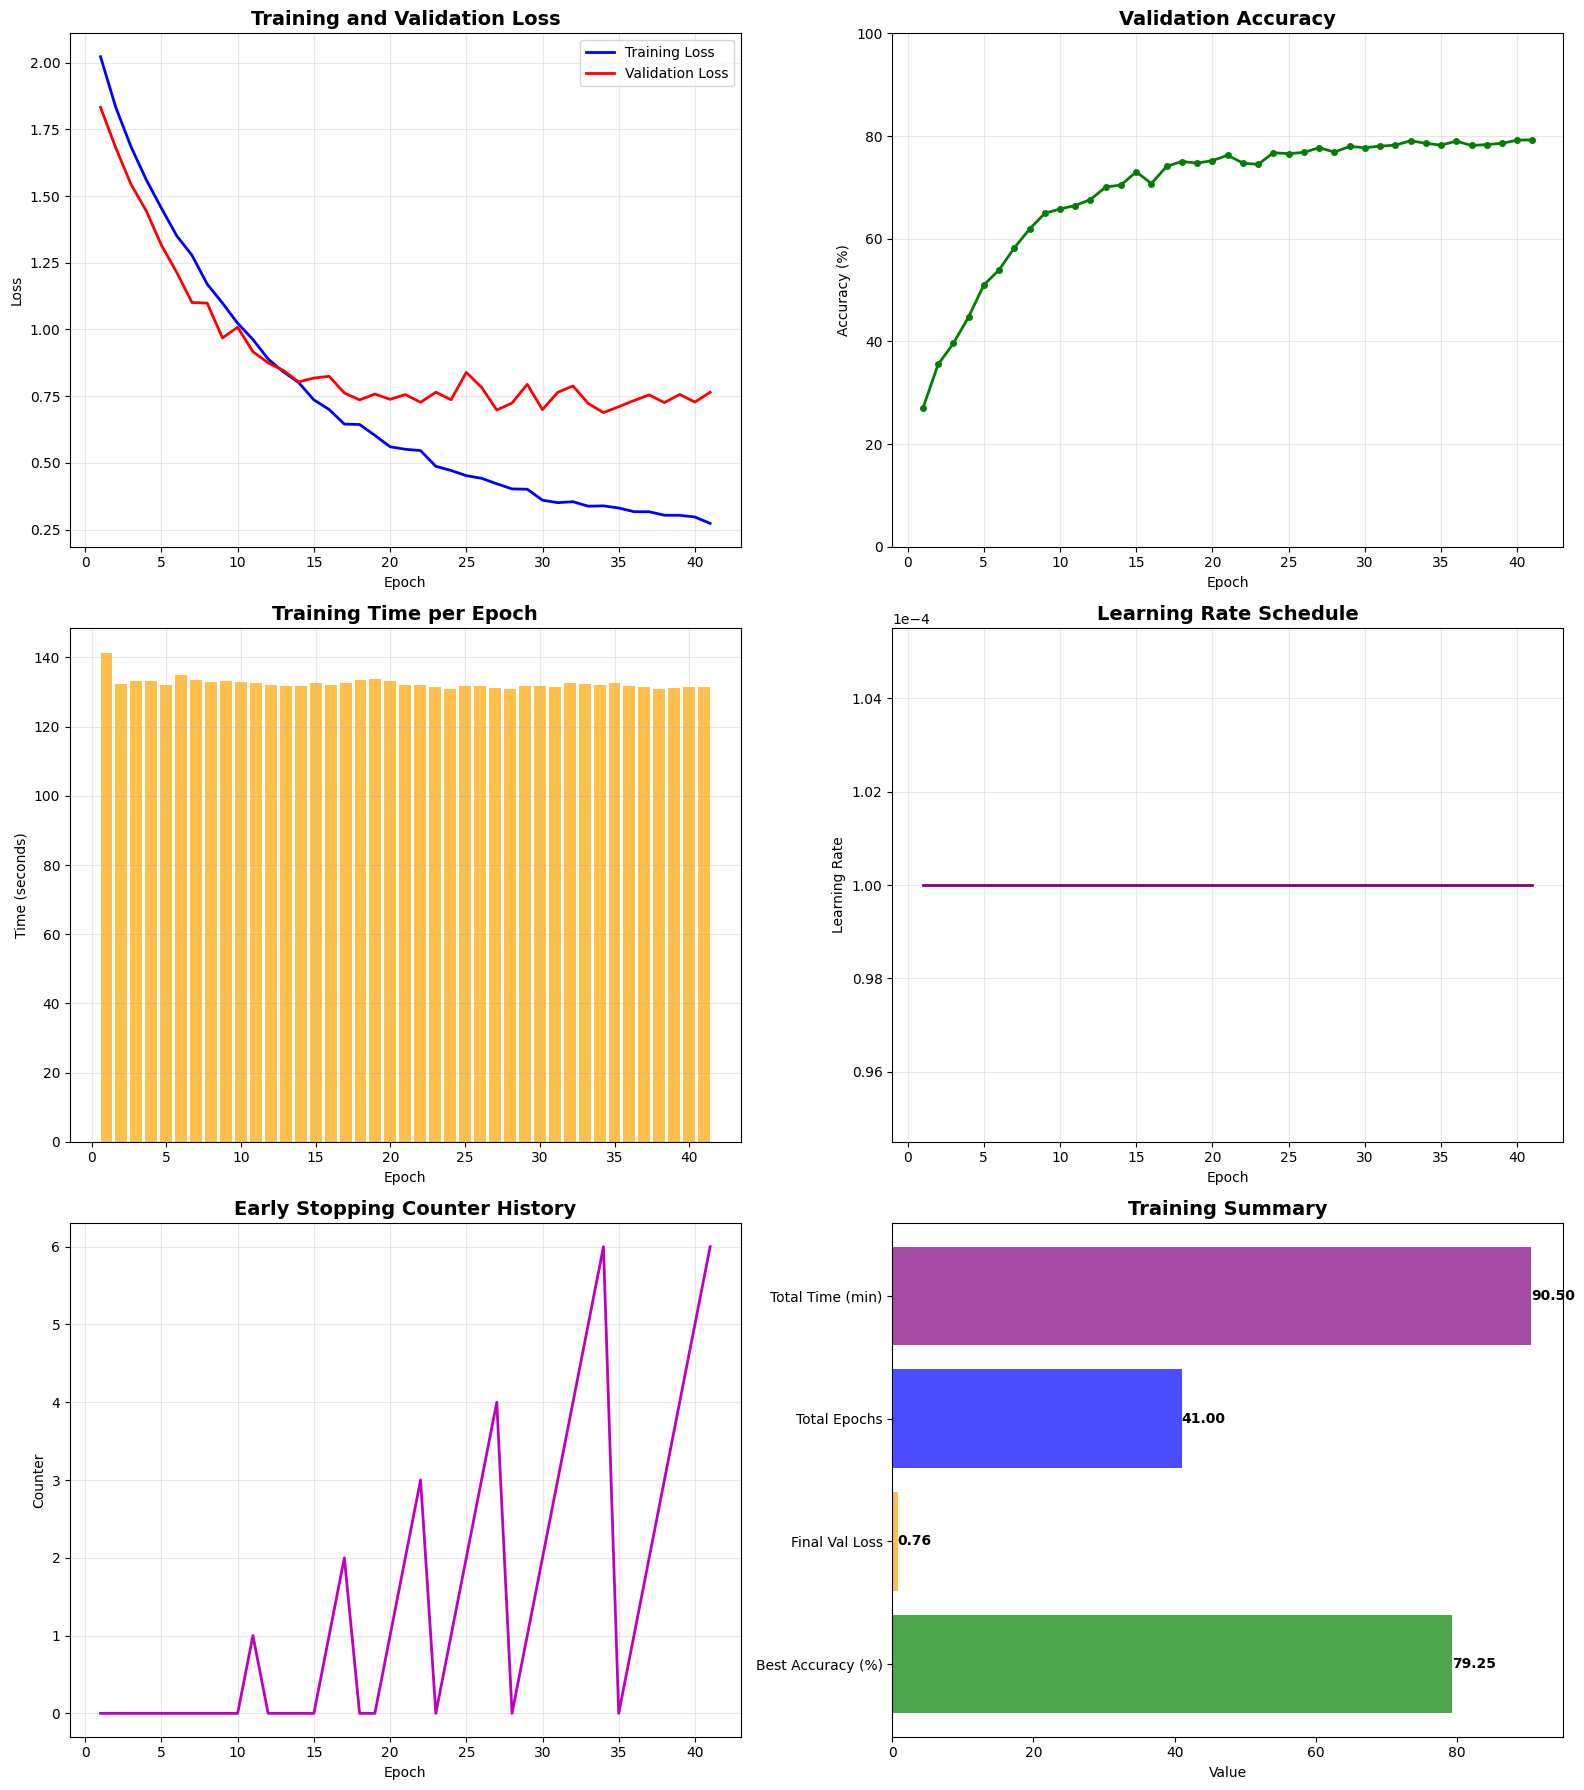


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 41/50.
Epochs saved: 9
Time saved: ~19.9 minutes
Efficiency gain: 18.0%

📈 Detailed Training Statistics:
- Loss Reduction: 2.0224 → 0.2730 (86.5% improvement)
- Best Accuracy: 79.25% (Epoch 41)
- Total Training Time: 90.50 minutes
- Average Time per Epoch: 132.44s
- Fastest Epoch: 130.80s
- Slowest Epoch: 141.36s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    37      0.3166    0.7545         78.15      131.53         0.0001           2
    38      0.3036    0.7258         78.34      130.97         0.0001           3
    39      0.3033    0.7563         78.58      131.05         0.0001           4
    40      0.2969    0.7279         79.19      131.39         0.0001           5
    41      

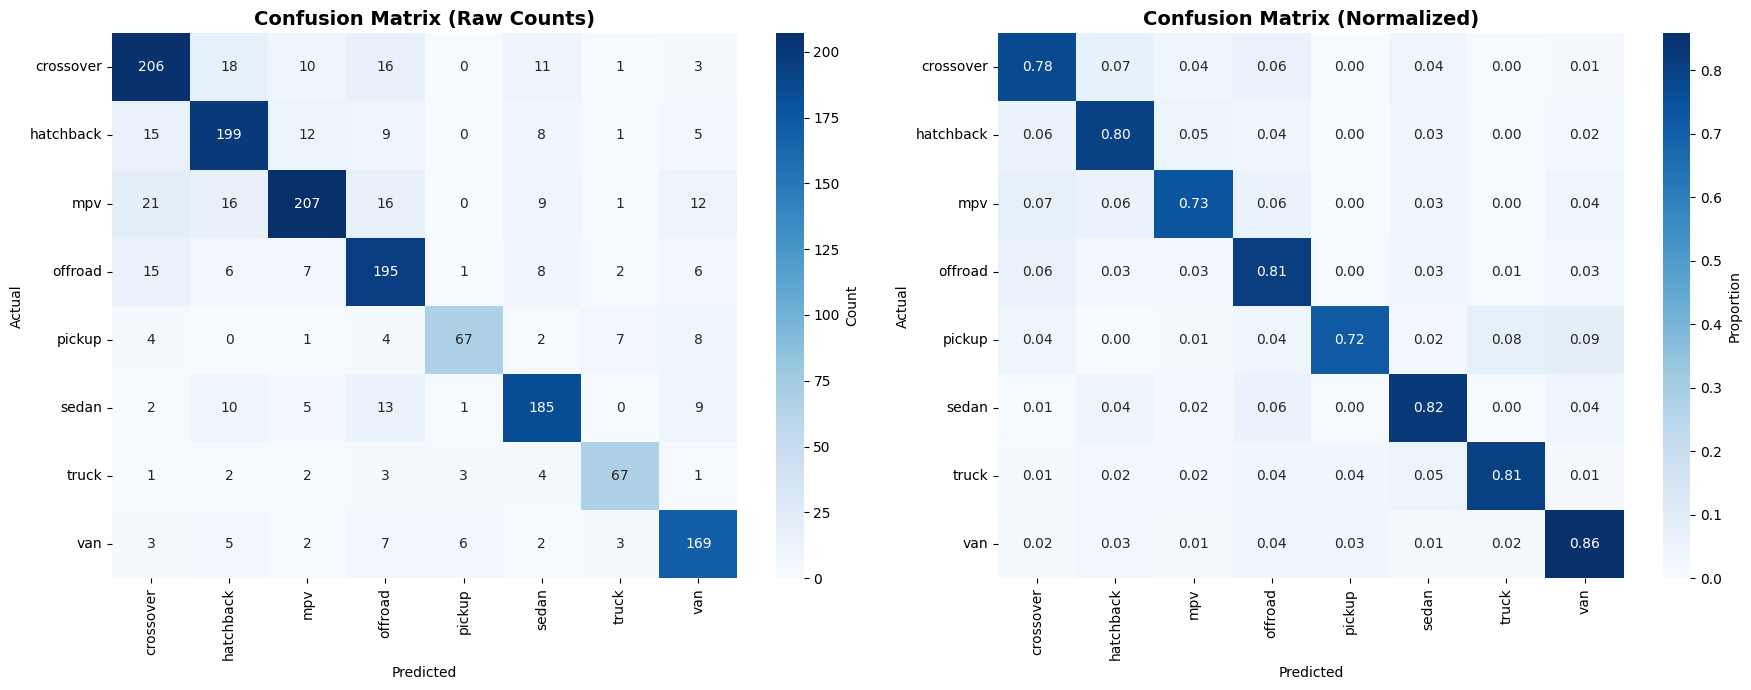


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   crossover     0.7715    0.7774    0.7744       265
   hatchback     0.7773    0.7992    0.7881       249
         mpv     0.8415    0.7340    0.7841       282
     offroad     0.7414    0.8125    0.7753       240
      pickup     0.8590    0.7204    0.7836        93
       sedan     0.8079    0.8222    0.8150       225
       truck     0.8171    0.8072    0.8121        83
         van     0.7934    0.8579    0.8244       197

    accuracy                         0.7925      1634
   macro avg     0.8011    0.7914    0.7946      1634
weighted avg     0.7950    0.7925    0.7924      1634


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['pickup', 'sedan', 'truck', 'van']
Average Accuracy: 80.19%
Majority Classes (4): ['crossover', 'hatchback', 'mpv', 'offroad']
Average Accuracy: 78.08%
Performance Gap: 2.12% (Minority better)


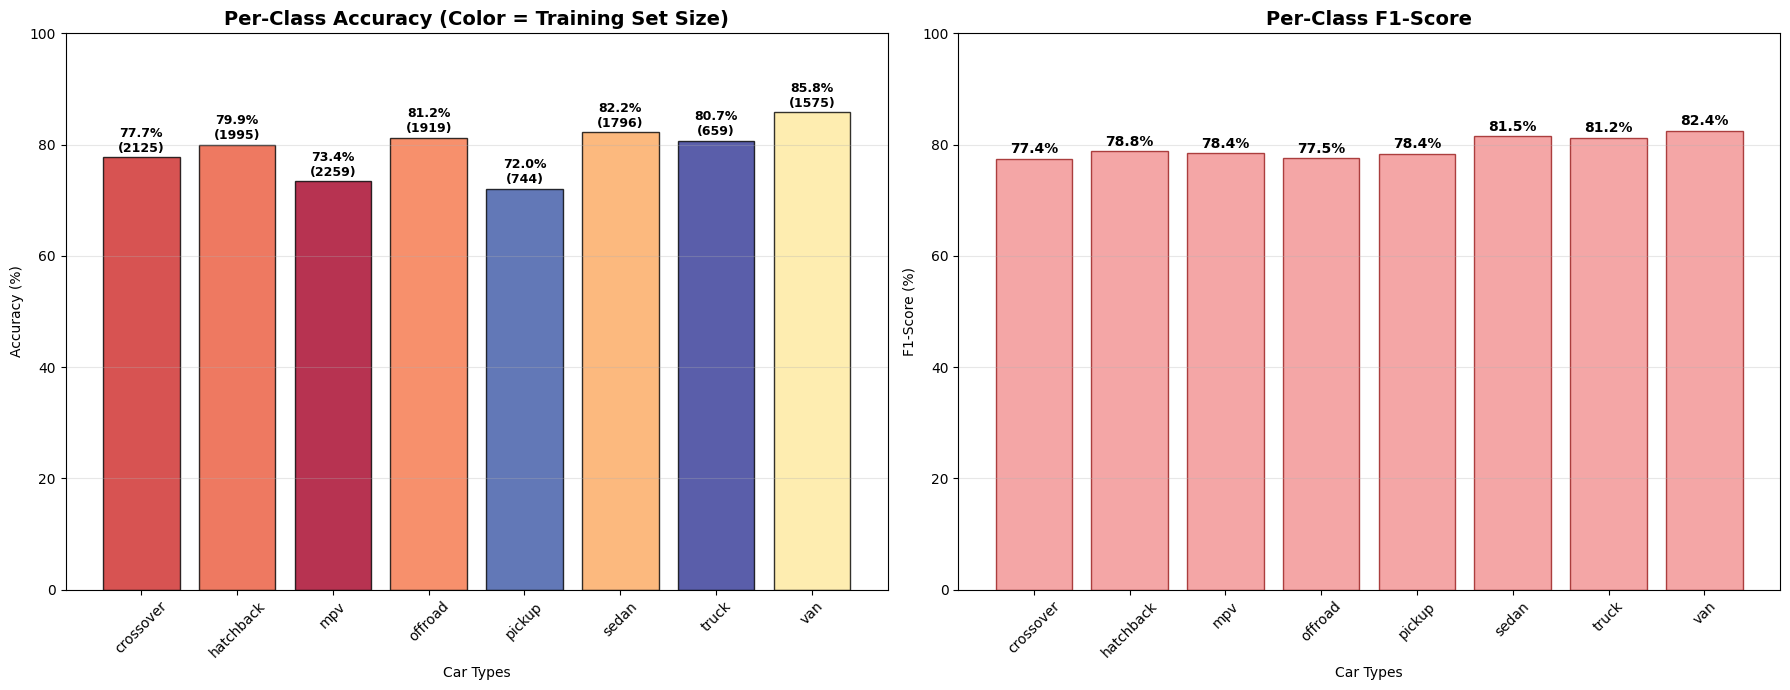

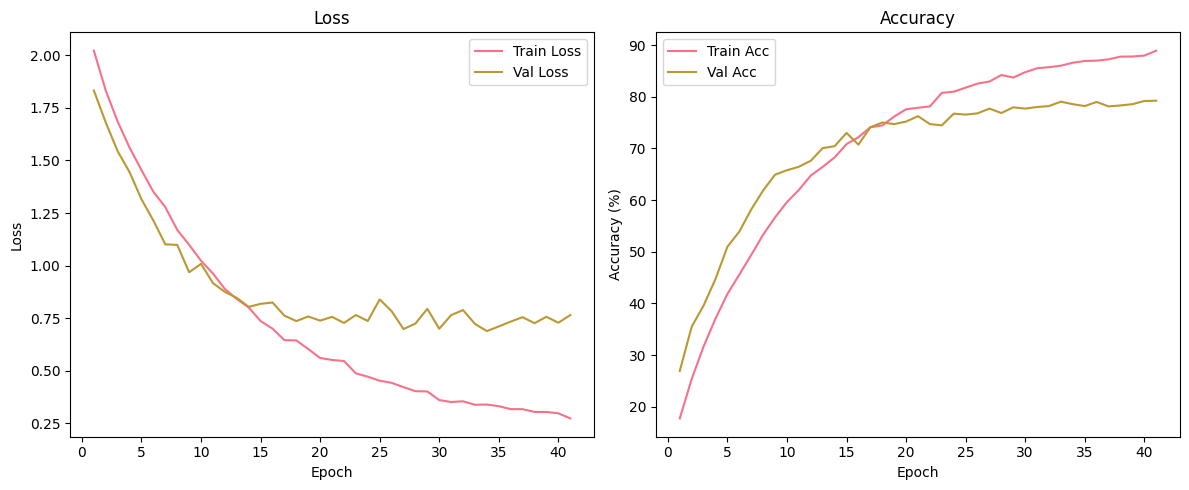

Final Train Loss: 0.2730 | Final Val Loss: 0.7644
Final Train Acc: 88.93% | Final Val Acc: 79.25%

🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250623_204706.json

💾 Training history saved to: models/classification/reports/training_history_20250623_204706.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250623_204706.csv
🎯 Best model saved to: models/results/carvit_model_20250623_191233.pth
🏆 Best accuracy model saved to: models/results/carvit_model_20250623_191233_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 41 epochs (planned: 50)
- Best validation accuracy: 79.25%
- Early stopping: Activated
- Total training time: 90.50 minutes
- Time saved by early stopping: 19.9 minutes
- Class imbalance: Moderate (ratio: 3.43x)
- Model saved with best validation loss: 0.688208


In [7]:
# Generate the full report
from models.classification.train_classification_eval import TrainingEvaluation

report = TrainingEvaluation(trainer, CONFIG, training_results)

report.full_report()

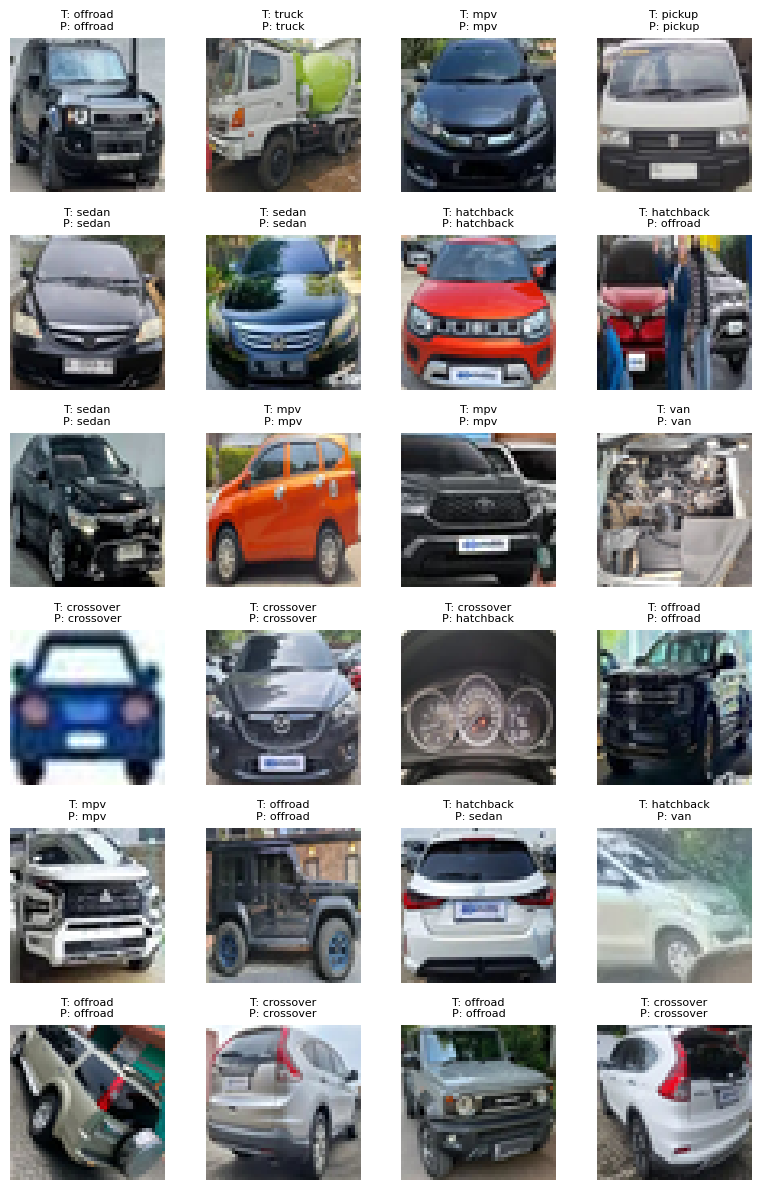

Test Accuracy: 83.33% (20/24)


In [7]:
# Test the classification model test images and display predictions
import os

from models.classification.test_classification import CarClassificationTester

test_dir = f"{DATASET_DIR}/test"
class_names = [
    d for d in sorted(os.listdir(test_dir)) if os.path.isdir(os.path.join(test_dir, d))
]
tester = CarClassificationTester(
    test_dir=test_dir,
    class_names=class_names,
    model_path=None,
    grid_rows=6,
    grid_cols=4,
    num_classes=CONFIG["num_classes"],
)

tester.plot_predictions()